In [1]:
# NeRV imports
import json
import os
import random
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap
from torch.utils.data import Subset

sys.path.append('../')

from get_mappings import ComputeContributions
from model_all_analysis import HNeRV
from vps_datasets import CityscapesVPSVideoDataSet, VIPSegVideoDataSet

In [4]:
class Args:
    pass

def load_model_args():
    args = Args()
    args.embed = 'pe_1.25_80'
    args.ks = '0_3_3'
    args.num_blks = '1_1'
    args.enc_dim = '64_16'
    args.enc_strds, args.dec_strds = [], [4, 2, 2]
    args.fc_dim = 37 
    args.fc_hw = '8_16'
    args.norm = 'none'
    args.act = 'gelu'
    args.reduce = 1.2
    args.lower_width = 6
    args.conv_type = ['convnext', 'pshuffel']
    args.b = 1
    args.out_bias = 0.0
    
    args.resize_list = '128_256'
    args.modelsize = 1.0
    
    args.dump_images=False
    
    return args

def load_model_checkpoint(model, args):
    checkpoint_path = args.weight
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    orig_ckt = checkpoint['state_dict']
    new_ckt={k.replace('blocks.0.',''):v for k,v in orig_ckt.items()} 
    if 'module' in list(orig_ckt.keys())[0] and not hasattr(model, 'module'):
        new_ckt={k.replace('module.',''):v for k,v in new_ckt.items()}
        missing = model.load_state_dict(new_ckt, strict=False)
    elif 'module' not in list(orig_ckt.keys())[0] and hasattr(model, 'module'):
        missing = model.module.load_state_dict(new_ckt, strict=False)
    else:
        missing = model.load_state_dict(new_ckt, strict=False)
    print(missing)
    print("=> loaded checkpoint '{}' (epoch {})".format(args.weight, checkpoint['epoch'])) 

    for param in model.parameters():
        param.requires_grad = False
        
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(pytorch_total_params)
        
    return model.cuda()

def worker_init_fn(worker_id):
    """
    Re-seed each worker process to preserve reproducibility
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    return

################## split one video into seen/unseen frames ##################
def data_split(img_list, split_num_list, shuffle_data, rand_num=0):
    valid_train_length, total_train_length, total_data_length = split_num_list
    # assert total_train_length < total_data_length
    temp_train_list, temp_val_list = [], []
    if shuffle_data:
        random.Random(rand_num).shuffle(img_list)
    for cur_i, frame_id in enumerate(img_list):
        if (cur_i % total_data_length) < valid_train_length:
            temp_train_list.append(frame_id)
        elif (cur_i % total_data_length) >= total_train_length:
            temp_val_list.append(frame_id)
    return temp_train_list, temp_val_list

# Annotations stuff
def convert_tensor_annotations_to_numpy(tensor_annotations):
    annotations = []
    
    for tensor_anno in tensor_annotations:
        annotation = {}

        annotation['id'] = tensor_anno['id'].item()
        annotation['inst_id'] = tensor_anno['inst_id'].item()
        annotation['image_id'] = tensor_anno['image_id'][0] #.item()
        annotation['category_id'] = tensor_anno['category_id'].item()
        annotation['area'] = tensor_anno['area'].item()
        annotation['iscrowd'] = tensor_anno['iscrowd'].item()
        annotation['isthing'] = tensor_anno['isthing'].item()

        # Convert 'bbox' back to regular format
        bbox = [bbox_tensor.item() for bbox_tensor in tensor_anno['bbox']]
        annotation['bbox'] = bbox

        annotation['binary_mask'] = tensor_anno['binary_mask'].numpy()
        
        annotations.append(annotation)

    return annotations

def add_other_annotation(annotations):

    # Create a mask that will indicate whether a location contains at least one instance
    object_region_mask = None
    for ann in annotations:
        binary_mask = ann['binary_mask'].squeeze()
        if object_region_mask is None:
            # If the object_region_mask is None, initialize it to current binary_mask otherwise aggregate it
            object_region_mask = binary_mask.copy()
        else:
            object_region_mask += binary_mask

    # Binarize
    object_region_mask = object_region_mask != 0
    
    # Create an annotation denoting "other" for regions that have no objects
    annotations.append({
        "id": -1,
        "inst_id": -1,
        "bbox": compute_bbox(object_region_mask),
        "area": object_region_mask.sum(),
        "binary_mask": object_region_mask,
        'iscrowd': 0,
        'isthing': 0,
        'category_id': -1,
        'image_id': annotations[0]['image_id']
    })
    return annotations

def compute_bbox(binary_mask):
    (rows, cols) = np.where(binary_mask > 0)
    x_min, x_max, y_min, y_max = min(cols), max(cols), min(rows), max(rows)
    # Create the bbox in COCO format [x, y, width, height]
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    bbox = [x_min, y_min, width, height]
    return bbox

def plot_image_with_instances(image, annotations, categories_dict, title=None):
    plt.rcParams["figure.figsize"] = 15, 10
    fig, ax = plt.subplots()

    # Plot the image
    ax.imshow(image)

    for anno in annotations:
        # Skip plotting "other" regions (regions without objects)
        if anno["category_id"] == -1:
            continue
        # Draw bbox
        x, y, w, h = anno["bbox"]
        cat_color = np.array(categories_dict[int(anno["category_id"])]['color']) / 255
        rectangle = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=cat_color, facecolor='none')
        ax.add_patch(rectangle)

        if 'binary_mask' in anno.keys():
            binary_mask = anno["binary_mask"].squeeze(0)
        else:
            raise ValueError("No binary mask found in annotation")
        # Create a mask where the binary mask is not zero
        mask = binary_mask != 0

        # Create rgba mask
        cmap = ListedColormap(cat_color)
        colored_mask = cmap(binary_mask.astype(float) / 1.0)

        # Create a mask where the binary mask is not zero
        mask = binary_mask != 0

        # Set the alpha channel to 0 for regions where the binary mask is zero
        colored_mask[:, :, 3] = mask.astype(float)
        
        # Display the colored mask over the image
        ax.imshow(colored_mask, alpha=0.5)

    if title is not None:
        plt.title(title)
    plt.show()

In [5]:
def load_dataset_specific_args(args, dataset_name, vidname):
    args.batchSize = args.b
    args.distributed = False
    args.workers = 4
    args.data_split='1_1_1'
    args.shuffle_data = False

    if dataset_name == "cityscapes":

        # Add cityscapes VPS paths
        args.cityscapes_vps_root = "../data/cityscapes_vps"
        args.split = "val"
        args.panoptic_video_mask_dir = os.path.join(args.cityscapes_vps_root, args.split, "panoptic_video")
        args.panoptic_inst_mask_dir = os.path.join(args.cityscapes_vps_root, args.split, "panoptic_inst")

        args.data_path = os.path.join(args.cityscapes_vps_root, args.split, "img_all")
        args.anno_path = '../data/cityscapes_vps/panoptic_gt_val_city_vps.json'

        args.vidname = vidname

        with open(args.anno_path, 'r') as f:
            panoptic_gt_val_city_vps = json.load(f)
                    
        panoptic_categories = panoptic_gt_val_city_vps['categories']   

        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}
        
    elif dataset_name == "vipseg":
        args.VIPSeg_720P_root = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P'
        args.panomasks_dir = os.path.join(args.VIPSeg_720P_root, "panomasks")
        args.panomasksRGB_dir = os.path.join(args.VIPSeg_720P_root, "panomasksRGB")
        args.data_path = os.path.join(args.VIPSeg_720P_root, "images")
        args.anno_path = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P/panoptic_gt_VIPSeg.json'

        args.vidname = vidname

        args.crop_list = '640_1280'

        with open(args.anno_path, 'r') as f:
            panoptic_gt_VIPSeg = json.load(f)
                    
        panoptic_categories = panoptic_gt_VIPSeg['categories']
        
        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}
        
    return args, categories_dict

In [ ]:
# Multiple videos and multiple RGB vs LAB models :)
dataset_names = ['cityscapes', 'vipseg']
vidnames = {
    'cityscapes': ['0005', '0175'],
    'vipseg': ['12_n-ytHkMceew', '26_cblDl5vCZnw']
}
vid_data_folder_name = {
    "cityscapes": "Cityscapes_VPS_models",
    "vipseg": "VIPSeg_models"
}


args_dict = {}
dataloader_dict = {}
weights_dict = {}
models_dict = {}
categories_dicts = {}

for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    args_dict[dataset_name] = {}
    dataloader_dict[dataset_name] = {}
    models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}
    
    for vidname in vidnames[dataset_name]:
        vid_data_folder = vid_data_folder_name[dataset_name]
        weights_dict[dataset_name][vidname] = f'../HNeRV/output/{vid_data_folder}/{vidname}_128_256_modelsize1.0/{vidname}/1_1_1_pe_1.25_80_Dim64_16_FC8_16_KS0_3_3_RED1.2_low6_blk1_1_e1000_b2_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.0_ENC_convnext__DEC_pshuffel_4,2,2_gelu1_1'
        
        args = load_model_args()
        
        args.weight = os.path.join(weights_dict[dataset_name][vidname], f'model_best.pth')
        args.crop_list = '-1' if dataset_name == "cityscapes" else '640_1280'

        model = HNeRV(args)  
        model = load_model_checkpoint(model, args)
        
        models_dict[dataset_name][vidname] = model
        
        # Add dataset specific args
        args, categories_dicts[dataset_name][vidname] = load_dataset_specific_args(args, dataset_name, vidname)
        
        args_dict[dataset_name][vidname] = args

In [7]:
# Create dataloader

for dataset_name in dataset_names:
     for vidname in vidnames[dataset_name]:
          
        args = args_dict[dataset_name][vidname]
        
        if dataset_name == "cityscapes":
            full_dataset = CityscapesVPSVideoDataSet(args)
        else:
            full_dataset = VIPSegVideoDataSet(args)
            
        sampler = torch.utils.data.distributed.DistributedSampler(full_dataset) if args.distributed else None

        args.final_size = full_dataset.final_size
        args.full_data_length = len(full_dataset)
        split_num_list = [int(x) for x in args.data_split.split('_')]
        train_ind_list, args.val_ind_list = data_split(list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0)

        #  Make sure the testing dataset is fixed for every run
        train_dataset =  Subset(full_dataset, train_ind_list)
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None
        # make sure that every field in annotations dict is not converted to tensor while constructing the dataloader

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batchSize, shuffle=False,#train_sampler is None),
            num_workers=args.workers, pin_memory=True, sampler=train_sampler, drop_last=True, worker_init_fn=worker_init_fn)#
    
        dataloader_dict[dataset_name][vidname] = train_dataloader

In [8]:
def compute_inference_results(dataset_name, vidname, train_dataloader, model, args, first_frame_only=True):

    if dataset_name == "vipseg":
        # Sample few frames
        num_indices = len(train_dataloader) * args.b
        num_samples = 6
        sampled_img_indices = [i * (num_indices - 1) // (num_samples - 1) for i in range(num_samples)]
    
    inference_results = {}
    with torch.no_grad():
        for batch in train_dataloader:
            img_data, norm_idx, img_idx = batch['img'].to('cuda'), batch['norm_idx'].to('cuda'), batch['idx'].to('cuda')

            if dataset_name == "vipseg" and (img_idx not in sampled_img_indices):
                continue
            
            images = batch['img'].cuda()
            downsample_results, stage_results, img_embed, decoder_results, img_out = model(norm_idx)
            
            
            # Save all input-output information related to annotated images
            inference_results[img_idx.item()] = {
                "decoder_results": decoder_results,
                "img_out": img_out,
                "img_gt": images[0],
            }
            
            if first_frame_only:
                break
    return inference_results

# Pick a model we care about

In [9]:
# Do for one video
dataset_name = 'cityscapes'
vidname = '0005'

train_dataloader = dataloader_dict[dataset_name][vidname]
model = models_dict[dataset_name][vidname]
categories_dict = categories_dicts[dataset_name][vidname]
args = args_dict[dataset_name][vidname]

In [10]:
inference_results = compute_inference_results(dataset_name, vidname, train_dataloader, model, args)

# 1. Pixels per neuron plot

In [37]:
def plot_pixels_per_neuron(vidname, inference_results, model, args, dump_raw_contribs=False):
    # for img_idx in list(inference_results.keys())[0:1]:
    img_idx = 0
    gt_img = inference_results[img_idx]["img_gt"]
    img_out = inference_results[img_idx]["img_out"]
    decoder_results = inference_results[img_idx]["decoder_results"]

    # Get model contributions
    compute_contrib_obj = ComputeContributions(
        model, args, decoder_results, img_out.detach().clone()[0]
    )

    head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
    nerv_blk_3_output_contrib, _ = compute_contrib_obj.compute_last_nerv_block_mappings()
    
    # Flatten by kernels and flatten by pixels
    head_layer_output_contrib_abs = torch.abs(head_layer_output_contrib).flatten(0,1).flatten(1,2)
    nerv_blk_3_output_contrib_abs = torch.abs(nerv_blk_3_output_contrib).flatten(0,1).flatten(1,2)
    
    # Sum contribs across kernels for each pixel
    head_contribs_fraction = head_layer_output_contrib_abs / head_layer_output_contrib_abs.sum(dim=0)
    blk_3_contribs_fraction = nerv_blk_3_output_contrib_abs / nerv_blk_3_output_contrib_abs.sum(dim=0)
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 10))
    # get a list of colors using tab20 cmap
    colors = plt.get_cmap('tab20').colors
    
    num_pixels_with_meaningful_contrib_dict = {}
    
    # size - num_kernels
    print(1 / head_layer_output_contrib_abs.size(0))
    head_num_pixels_with_meaningful_contrib = (head_contribs_fraction > (1 / head_layer_output_contrib_abs.size(0))).sum(dim=1)
    blk_3_num_pixels_with_meaningful_contrib = (blk_3_contribs_fraction > (1 / nerv_blk_3_output_contrib_abs.size(0))).sum(dim=1)
    
    # Sort
    head_num_pixels_with_meaningful_contrib, _ = torch.sort(head_num_pixels_with_meaningful_contrib)
    
    blk_3_num_pixels_with_meaningful_contrib, _ = torch.sort(blk_3_num_pixels_with_meaningful_contrib)

    axs.plot(head_num_pixels_with_meaningful_contrib, color='b', label=f"Threshold - 1/num_kernels")
    axs.plot(blk_3_num_pixels_with_meaningful_contrib, color='g', label=f"Threshold - 1/num_kernels")

    axs.set_xlabel("Neuron index")
    axs.set_ylabel("Number of pixels")
    axs.set_title(f"Head layer")
    
    num_pixels_with_meaningful_contrib_dict = {
        "head": head_num_pixels_with_meaningful_contrib,
        "blk_3": blk_3_num_pixels_with_meaningful_contrib
    }

    legend, handles = axs.get_legend_handles_labels()
    fig.legend(legend, handles)
    fig.suptitle(f"Frame {img_idx} - Number of pixels contributed to by neuron (above Threshold)")
    plt.show()
        
    return num_pixels_with_meaningful_contrib_dict

0.015151515151515152


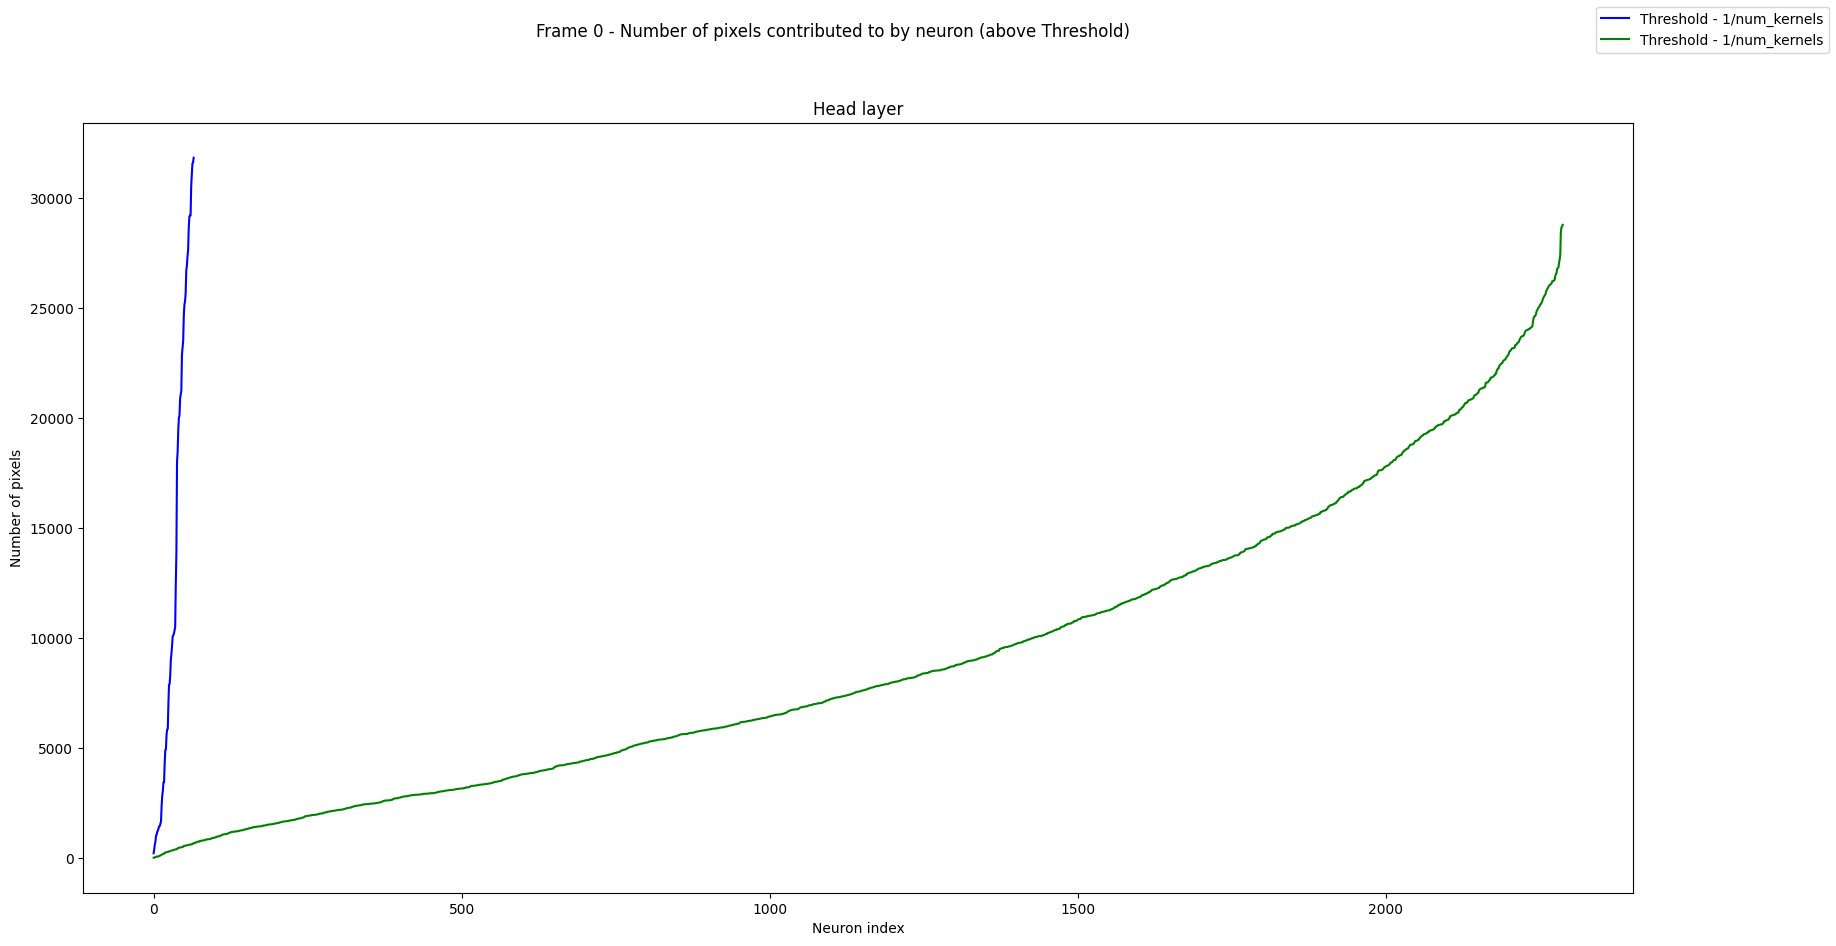

In [39]:
num_pixels_with_meaningful_contrib_dict = plot_pixels_per_neuron(vidname, inference_results, model, args)

# 2. Neurons per pixel heatmap (alongside GT)

In [11]:
def compute_contrib_thresh_using_auc(abs_contrib_map , target_area=0.05):
    # Still slow for block 3 where there are 2800 kernels
    total_sum = abs_contrib_map.sum()

    cutoff_contrib_sum = total_sum * (1 - target_area)

    # Flatten the tensor and calculate cumulative sum
    sorted_contributions = abs_contrib_map.flatten()
    sorted_indices = torch.argsort(sorted_contributions, descending=True)
    cum_sum = torch.cumsum(sorted_contributions[sorted_indices], dim=0)

    # Find the index where cumulative sum exceeds the cutoff
    idx = torch.nonzero(cum_sum >= cutoff_contrib_sum, as_tuple=False)[0, 0].item()
    chosen_thresh = sorted_contributions[sorted_indices][idx]
    
    # print(chosen_thresh)
    return chosen_thresh

In [12]:
def plot_neurons_per_pixel_heatmap(vidname, inference_results, model, args):
    # for img_idx in list(inference_results.keys())[0::4]:
    img_idx = 0
    gt_img = inference_results[img_idx]["img_gt"]
    img_out = inference_results[img_idx]["img_out"]
    decoder_results = inference_results[img_idx]["decoder_results"]

    # Get model contributions
    compute_contrib_obj = ComputeContributions(
        model, args, decoder_results, img_out.detach().clone()[0]
    )

    head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
    nerv_blk_3_output_contrib, _ = compute_contrib_obj.compute_last_nerv_block_mappings()
    
    # Flatten by kernels only
    head_layer_output_contrib_abs = torch.abs(head_layer_output_contrib).flatten(0,1)
    nerv_blk_3_output_contrib_abs = torch.abs(nerv_blk_3_output_contrib).flatten(0,1)

    target_areas = [0.1, 0.5]
    
    num_kernels_with_meaningful_contrib = {}
    
    # Separate subplots for different target area thresholds
    for target_area in target_areas:
        fig, axs = plt.subplots(1, 3, figsize=(20, 10))
        
        # Compute head and block 3 kernel threshold contributions
        head_thresh = compute_contrib_thresh_using_auc(abs_contrib_map = head_layer_output_contrib_abs, target_area = target_area)
        blk_3_thresh = compute_contrib_thresh_using_auc(abs_contrib_map = nerv_blk_3_output_contrib_abs, target_area = target_area) 
        
        # size - num_kernels
        # Find total number of neurons over threshold and divide by total number 
        head_num_kernels_with_meaningful_contrib = (head_layer_output_contrib_abs > head_thresh).sum(dim=0) / head_layer_output_contrib_abs.size(0)
        blk_3_num_kernels_with_meaningful_contrib = (nerv_blk_3_output_contrib_abs > blk_3_thresh).sum(dim=0) / nerv_blk_3_output_contrib_abs.size(0)

        axs[0].imshow(torch.clamp(gt_img, 0, 1).permute(1,2,0).cpu().numpy()) # in final plot, we will change this to be full res RGB image
        im1 = axs[1].imshow(head_num_kernels_with_meaningful_contrib, cmap='magma')
        im2 = axs[2].imshow(blk_3_num_kernels_with_meaningful_contrib, cmap='magma')
        
        axs[0].set_title("Ground Truth Image")
        axs[1].set_title(f"Head Layer Heatmap - head_thresh={head_thresh:.4f}")
        # only print upto 4 decimal places
        axs[2].set_title(f"Block 3 Heatmap - blk_3_thresh={blk_3_thresh:.4f}")
        

        for ax in axs:
            ax.axis('off')
        
        num_kernels_with_meaningful_contrib[target_area] = {
            "head": head_num_kernels_with_meaningful_contrib,
            "blk_3": blk_3_num_kernels_with_meaningful_contrib
        }

        # fig.suptitle(f"Neurons per Pixel Heatmap (Meaningful Contribution above Target Area Under Curve {target_area})", y=0.8)
        fig.suptitle(f"Neurons per Pixel Heatmap (Contributions above Target Area Under Sorted Curve {target_area})", y=0.7)
        
        plt.show()
    
    return num_kernels_with_meaningful_contrib

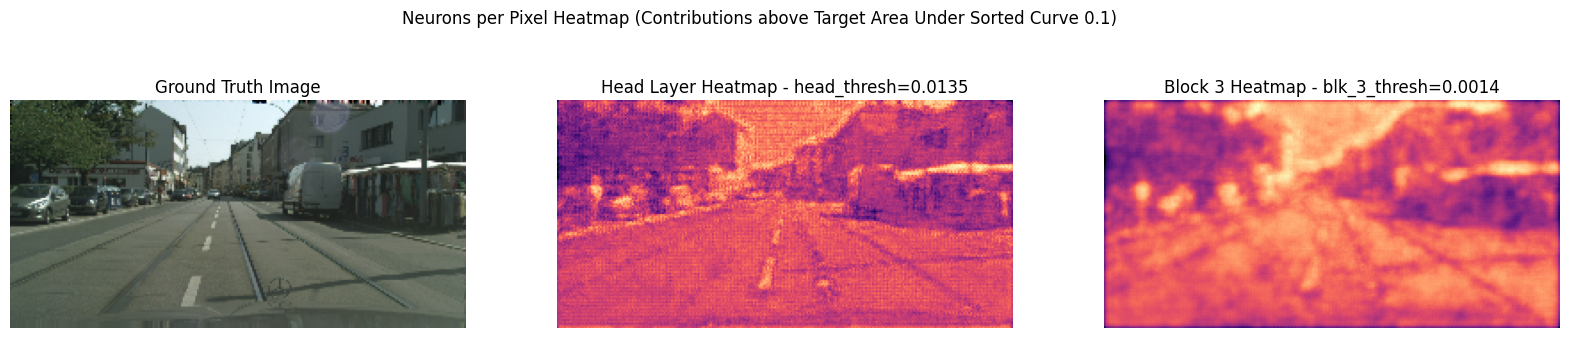

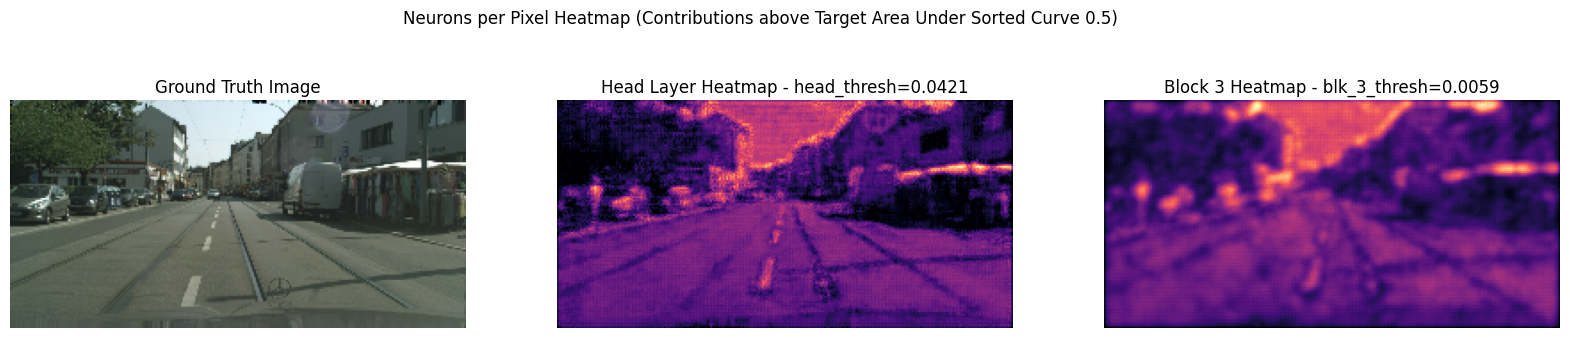

In [13]:
num_kernels_with_meaningful_contrib = plot_neurons_per_pixel_heatmap(vidname, inference_results, model, args)

# Different videos

0.015151515151515152


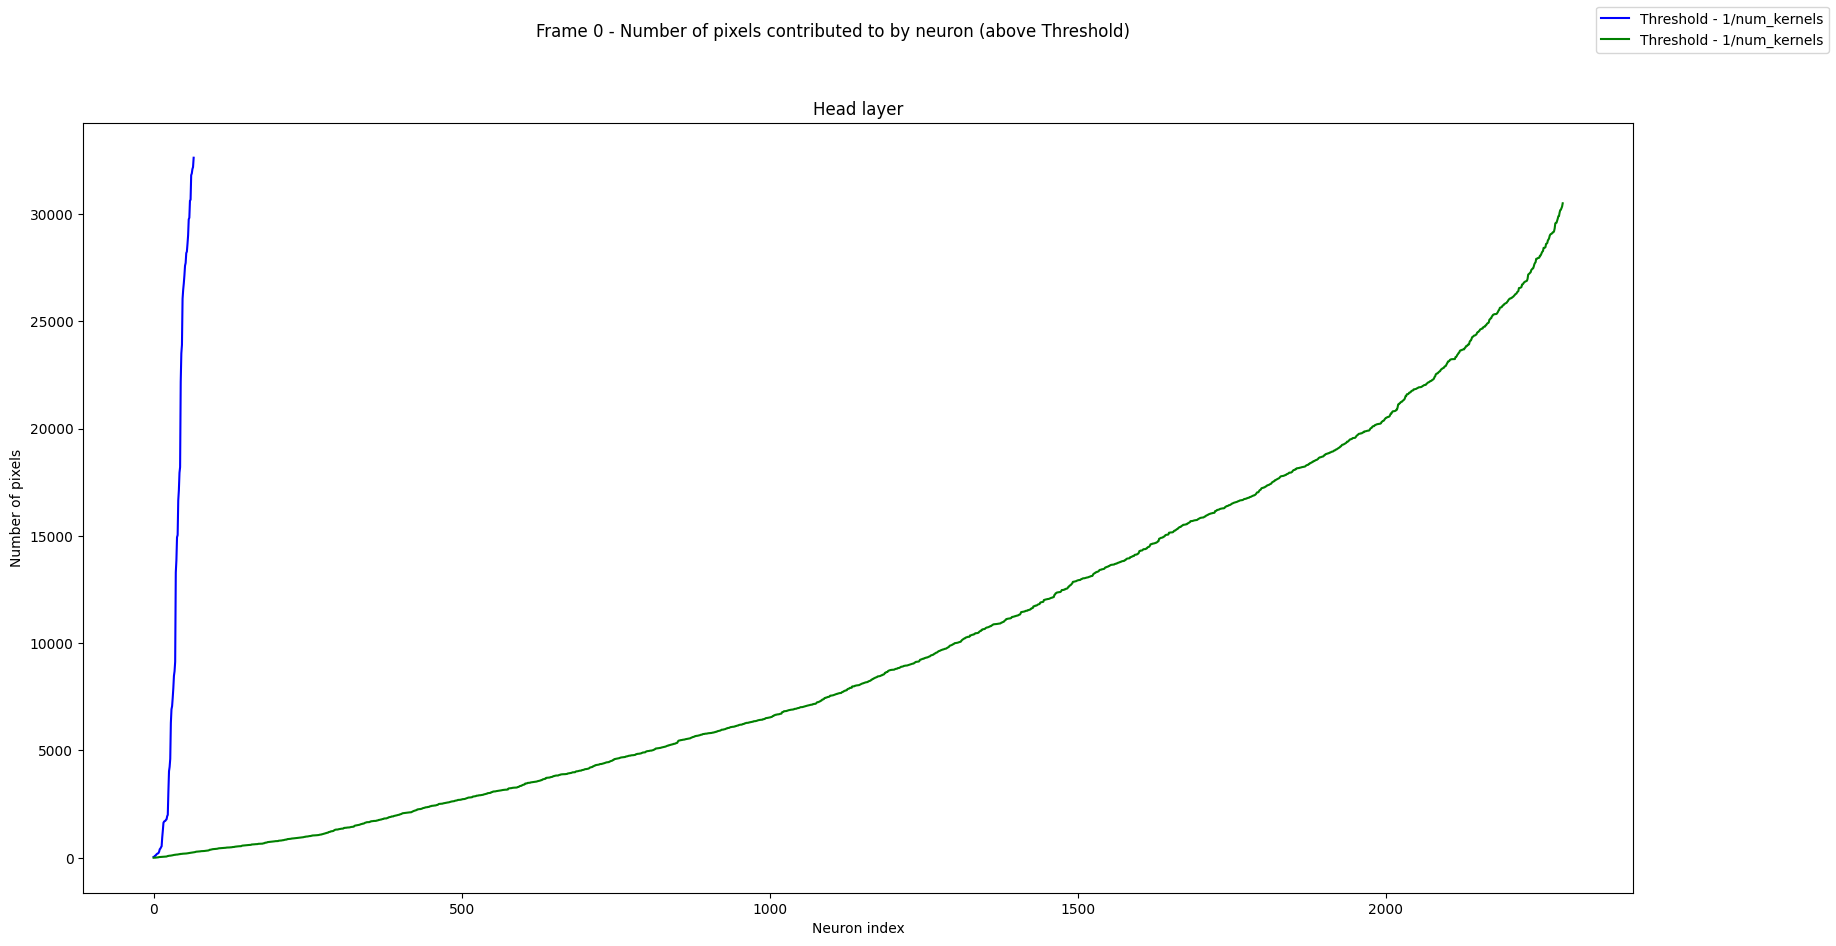

0.015151515151515152


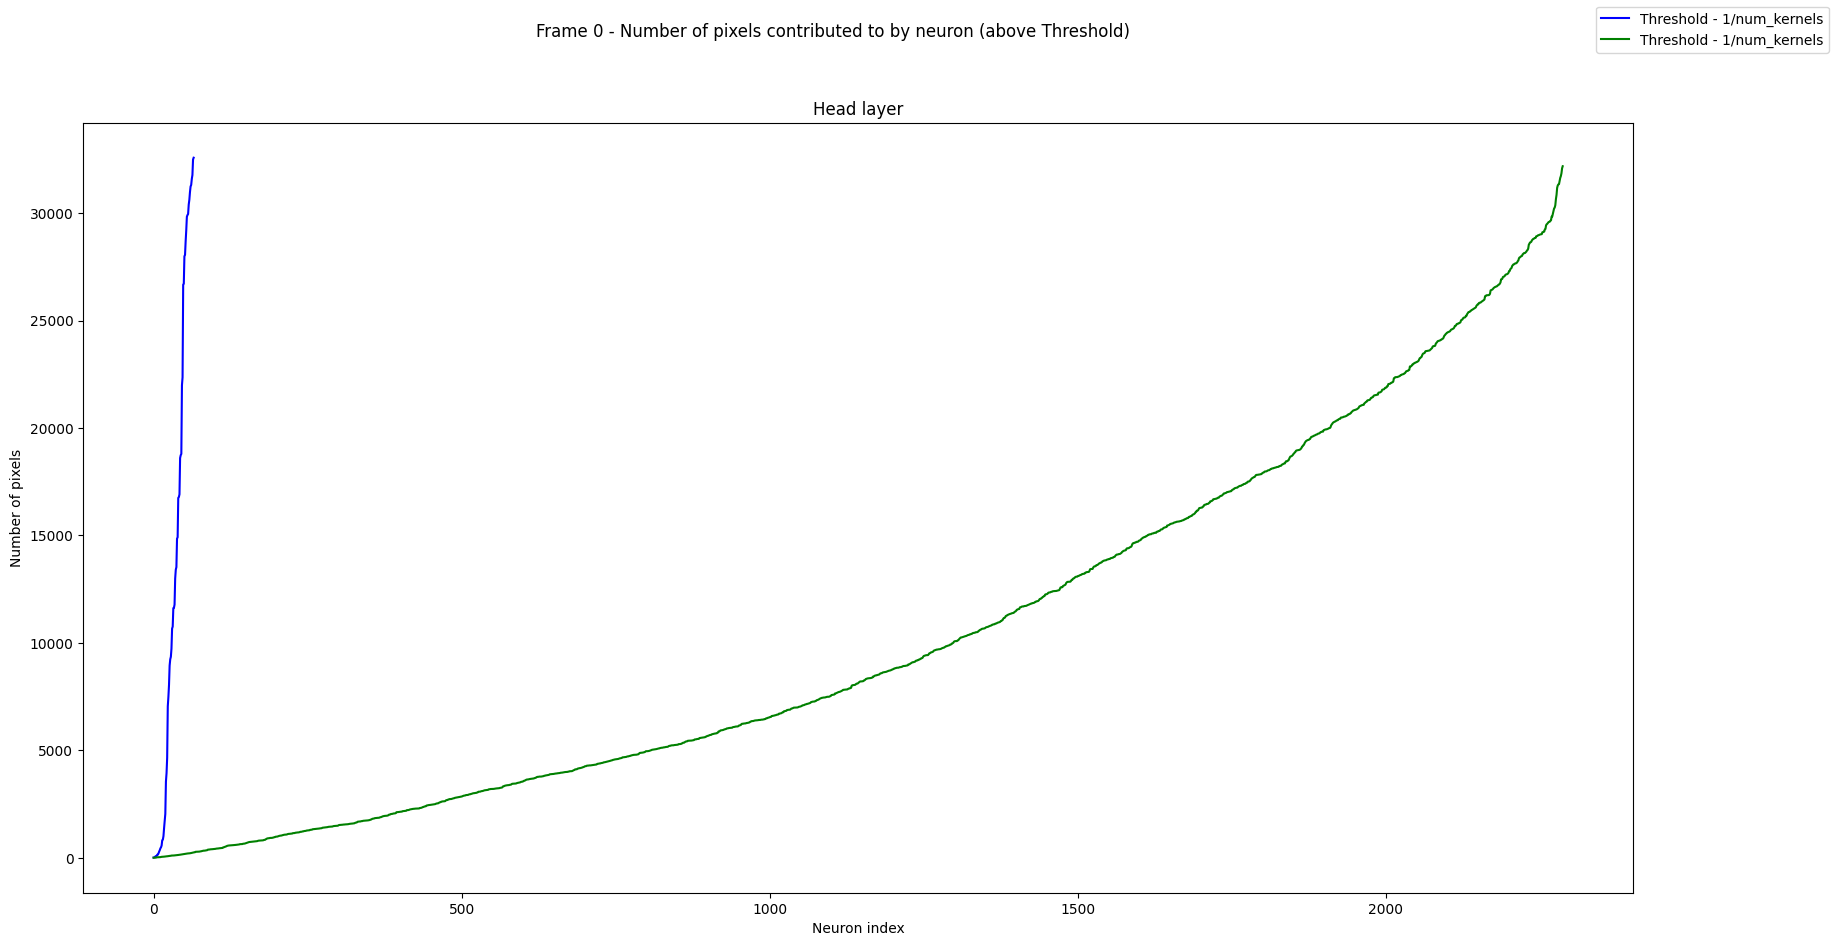

0.015151515151515152


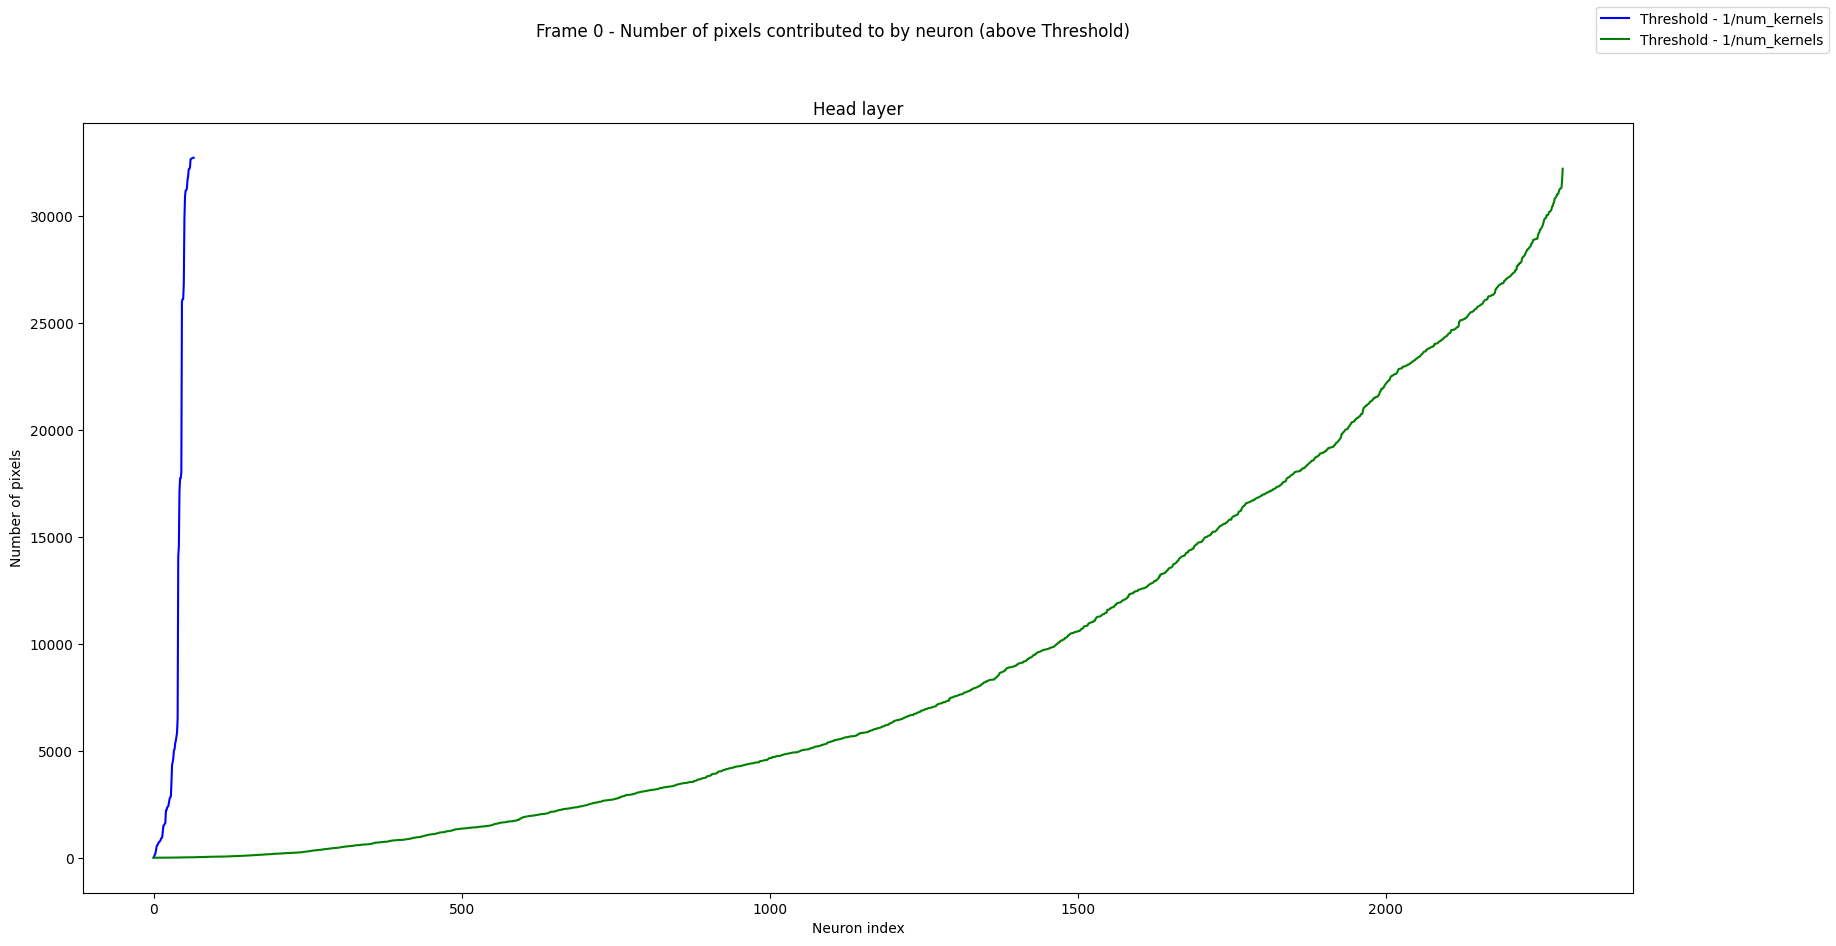

0.015151515151515152


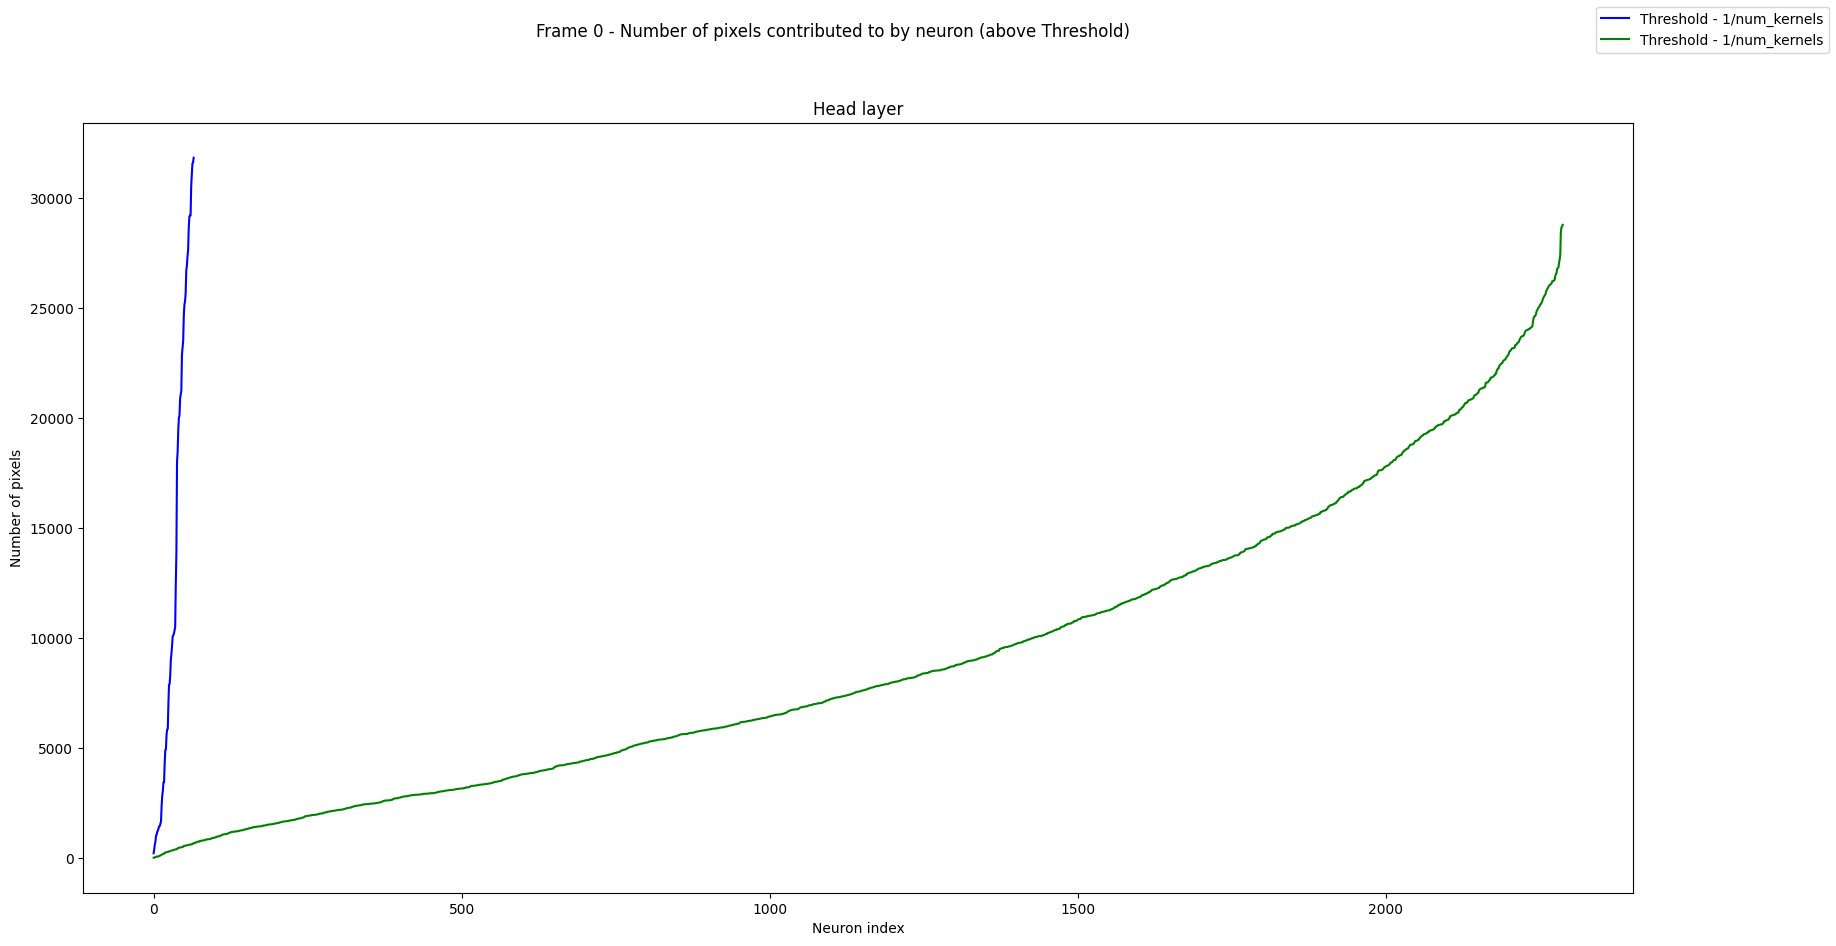

In [41]:
# Different models
per_vid_num_pixels_with_meaningful_contrib = {}
per_vid_num_kernels_with_meaningful_contrib = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        train_dataloader = dataloader_dict[dataset_name][vidname]
        model = models_dict[dataset_name][vidname]
        categories_dict = categories_dicts[dataset_name][vidname]
        args = args_dict[dataset_name][vidname]
        
        inference_results = compute_inference_results(dataset_name, vidname, train_dataloader, model, args)
        per_vid_num_pixels_with_meaningful_contrib[vidname] = plot_pixels_per_neuron(vidname, inference_results, model, args)
        per_vid_num_kernels_with_meaningful_contrib[vidname] = plot_neurons_per_pixel_heatmap(vidname, inference_results, model, args)

# Dump raw values for final plotting

In [42]:
import pickle


# Save the per_vid_num_pixels_with_meaningful_contrib and per_vid_num_kernels_with_meaningful_contrib to files

save_dir = '../plotting_source_data/NeRV/B-representation_is_distributed'
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, f"per_vid_num_pixels_with_meaningful_contrib.pkl"), 'wb') as f:
    pickle.dump(per_vid_num_pixels_with_meaningful_contrib, f)
with open(os.path.join(save_dir, f"per_vid_num_kernels_with_meaningful_contrib.pkl"), 'wb') as f:
    pickle.dump(per_vid_num_kernels_with_meaningful_contrib, f)
